In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [11]:
import torch
import torch.utils.data as data
import torchvision.datasets as dset
from torchvision import transforms

batch_size = 256 # 256

img_dir_t = './Perfect_data/train/'

train_dataset = dset.ImageFolder(img_dir_t, transform = transforms.Compose([transforms.ToTensor()]))

img_dir_te = './Perfect_data/val/'
test_dataset = dset.ImageFolder(img_dir_te, transform = transforms.Compose([transforms.ToTensor()]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 30         # 전체 classes 수

In [12]:
l_t = []

for i in range(len(train_dataset)):
    train_dataset.train_label = train_dataset.__getitem__(i)[1]
    l_t.append(train_dataset.train_label)

train_dataset.train_labels = torch.Tensor(l_t)

In [13]:
train_dataset.train_labels

tensor([ 0.,  0.,  0.,  ..., 29., 29., 29.])

In [14]:
l_te = []

for i in range(len(test_dataset)):
    test_dataset.test_label = test_dataset.__getitem__(i)[1]
    l_te.append(test_dataset.test_label)

test_dataset.test_labels = torch.Tensor(l_te)

In [15]:
test_dataset.test_labels

tensor([ 0.,  0.,  0.,  ..., 29., 29., 29.])

In [16]:
train_dataset.classes

['11_Starbucks',
 '12_Vans',
 '13_Burberry',
 '14_ALDO',
 '15_Polo',
 '16_ClubMonaco',
 '17_HatsOn',
 '18_Guess',
 '19_Victoria',
 '20_TheBodyShop',
 '21_Brooks',
 '22_Zara',
 '23_VanHart',
 '24_Starfield',
 '25_Lacoste',
 '26_Hollys',
 '27_Converse',
 '28_Fendi',
 '29_Chicor',
 '30_Custom',
 '31_Yankee',
 '32_Tommy',
 '33_GS',
 '34_KizDom',
 '35_Cartier',
 '36_Hermes',
 '37_HM',
 '38_Gucci',
 '39_AT',
 '40_Chanel']

In [17]:
train_dataset.__len__()

5467

In [18]:
test_dataset.__len__()

5467

## Common setup

In [19]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['11_Starbucks',
 '12_Vans',
 '13_Burberry',
 '14_ALDO',
 '15_Polo',
 '16_ClubMonaco',
 '17_HatsOn',
 '18_Guess',
 '19_Victoria',
 '20_TheBodyShop',
 '21_Brooks',
 '22_Zara',
 '23_VanHart',
 '24_Starfield',
 '25_Lacoste',
 '26_Hollys',
 '27_Converse',
 '28_Fendi',
 '29_Chicor',
 '30_Custom',
 '31_Yankee',
 '32_Tommy',
 '33_GS',
 '34_KizDom',
 '35_Cartier',
 '36_Hermes',
 '37_HM',
 '38_Gucci',
 '39_AT',
 '40_Chanel']

mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(30):         
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [20]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 5467
    Root location: ./Perfect_data/train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [21]:
import torch.nn as nn
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=30, n_samples=16)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=30, n_samples=16)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet128
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric, AccumulatedAccuracyMetric

margin = 1.

###
# embedding_net = EmbeddingNet().to(device)
# model = TripletNet(embedding_net)
# model = nn.DataParallel(model)

# ##
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# embedding_net = EmbeddingNet128().to(device)
# model = embedding_net
# # model = nn.DataParallel(model)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# embedding_net = EmbeddingNet().to(device)
model = torch.load('EmbeddingNet')
model = model.to(device)
model.eval()

if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
lr = 2e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


n_epochs = 20
log_interval = 150

In [22]:
# fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [23]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
resnet.0.module.conv1.weight 	 torch.Size([64, 3, 7, 7])
resnet.0.module.bn1.weight 	 torch.Size([64])
resnet.0.module.bn1.bias 	 torch.Size([64])
resnet.0.module.bn1.running_mean 	 torch.Size([64])
resnet.0.module.bn1.running_var 	 torch.Size([64])
resnet.0.module.bn1.num_batches_tracked 	 torch.Size([])
resnet.0.module.layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
resnet.0.module.layer1.0.bn1.weight 	 torch.Size([64])
resnet.0.module.layer1.0.bn1.bias 	 torch.Size([64])
resnet.0.module.layer1.0.bn1.running_mean 	 torch.Size([64])
resnet.0.module.layer1.0.bn1.running_var 	 torch.Size([64])
resnet.0.module.layer1.0.bn1.num_batches_tracked 	 torch.Size([])
resnet.0.module.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
resnet.0.module.layer1.0.bn2.weight 	 torch.Size([64])
resnet.0.module.layer1.0.bn2.bias 	 torch.Size([64])
resnet.0.module.layer1.0.bn2.running_mean 	 torch.Size([64])
resnet.0.module.layer1.0.bn2.running_var 	 torch.Size([64])
resnet.0.module

In [12]:
# torch.save(model, 'EmbeddingNet')

In [13]:
# model = torch.load('EmbeddingNet')
# model.eval()

EmbeddingNet128(
  (resnet): Sequential(
    (0): DataParallel(
      (module): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [1]:
# # 모델 저장
# torch.save(model.state_dict(), 'EmbeddingNet.pt')

NameError: name 'torch' is not defined

In [ ]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [24]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
test_embeddings_otl, test_labels_otl = extract_embeddings(test_loader, model)

In [25]:
train_embeddings_otl

array([[ 2.5928359 ,  0.95704192,  1.3850714 , ...,  5.4748888 ,
         0.14750038, -3.52593327],
       [ 2.33720779,  0.70074618,  1.90264225, ...,  5.24366188,
         0.02859598, -4.01397943],
       [ 2.00109982,  0.97648931,  1.12432122, ...,  4.91914988,
        -0.1368264 , -3.23025799],
       ...,
       [-7.92659521,  2.12712932, -0.3372767 , ..., -3.59259272,
         6.51657486, -7.72856808],
       [-4.99863195,  0.72801155,  1.36192131, ..., -2.23540187,
         3.85645247, -4.36508942],
       [-6.00721598,  1.08879447, -0.05879822, ..., -3.24306345,
         5.21924448, -4.43905973]])

In [26]:
train_dict = {
    0:'11_Starbucks',
 1:'12_Vans',
 2:'13_Burberry',
 3:'14_ALDO',
 4:'15_Polo',
 5:'16_ClubMonaco',
 6:'17_HatsOn',
 7:'18_Guess',
 8:'19_Victoria',
 9:'20_TheBodyShop',
 10:'21_Brooks',
 11:'22_Zara',
 12:'23_VanHart',
 13:'24_Starfield',
 14:'25_Lacoste',
 15:'26_Hollys',
 16:'27_Converse',
 17:'28_Fendi',
 18:'29_Chicor',
 19:'30_Custom',
 20:'31_Yankee',
 21:'32_Tommy',
 22:'33_GS',
 23:'34_KizDom',
 24:'35_Cartier',
 25:'36_Hermes',
 26:'37_HM',
 27:'38_Gucci',
 28:'39_AT',
 29:'40_Chanel'}

In [27]:
train_label_otl = []
for i in range(len(train_labels_otl)):
    train_labels = train_dict[train_labels_otl[i]]
    train_label_otl.append(train_labels)

In [28]:
test_dict = {
    0:'11_Starbucks',
 1:'12_Vans',
 2:'13_Burberry',
 3:'14_ALDO',
 4:'15_Tag',
 5:'16_ClubMonaco',
 6:'17_HatsOn',
 7:'18_Guess',
 8:'19_Victoria',
 9:'20_Forever21',
 10:'21_Brooks',
 11:'22_Zara',
 12:'23_VanHart',
 13:'24_Starfield',
 14:'25_Lacoste',
 15:'26_Hollys',
 16:'27_Converse',
 17:'28_Fendi',
 18:'29_Chicor',
 19:'30_Custom',
 20:'31_Yankee',
 21:'32_Tommy',
 22:'33_GS',
 23:'34_KizDom',
 24:'35_Cartier',
 25:'36_Hermes',
 26:'37_HM',
 27:'38_Gucci',
 28:'39_AT',
 29:'40_Chanel'}

In [29]:
test_label_otl = []
for i in range(len(test_labels_otl)):
    test_labels = test_dict[test_labels_otl[i]]
    test_label_otl.append(test_labels)

In [30]:
def distance(emb1, emb2):
    emb1 = emb1/np.linalg.norm(emb1, ord = 2)
    emb2 = emb2/np.linalg.norm(emb2, ord = 2)
    return np.sum(np.square(emb1 - emb2))

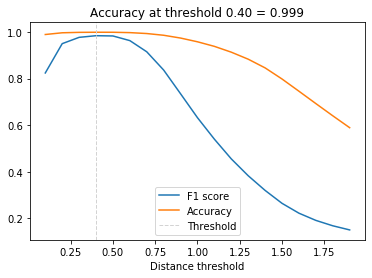

In [33]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(train_embeddings_otl)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(train_embeddings_otl[i], test_embeddings_otl[j]))
        identical.append(1 if train_label_otl[i] == test_label_otl[j] else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.1, 2, 0.1)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

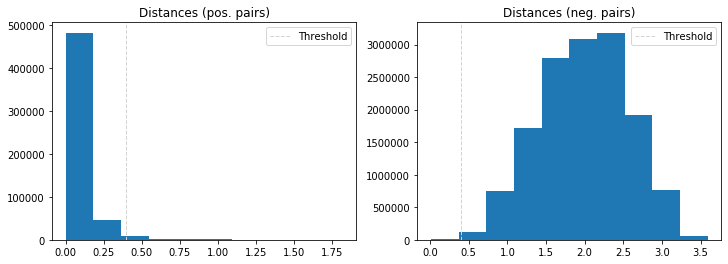

In [35]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [36]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)



In [39]:
metadata2 = load_metadata('./Perfect_data/train')

In [40]:
metadata3 = load_metadata('./Perfect_data/val')

In [41]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [42]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(train_embeddings_otl[idx1], test_embeddings_otl[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata2[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata3[idx2].image_path()));    

No handles with labels found to put in legend.


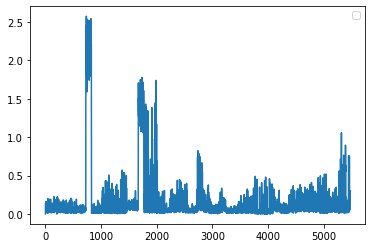

In [44]:
k = []
for i in range(len(train_embeddings_otl)):
    k.append(round(distance(train_embeddings_otl[i], test_embeddings_otl[i]), 4))
w = np.arange(0, len(train_embeddings_otl), 1)
plt.plot(w, k);
plt.legend();

before: 15_Polo after: 15_Tag
before: 20_TheBodyShop after: 20_Forever21


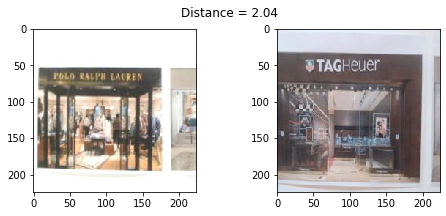

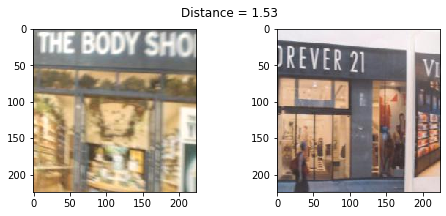

In [60]:
from collections import Counter

label_c = Counter(test_label_otl)

samples = []
for i in range(len(test_dict)):
    samples.append(label_c[test_dict[i]])
    
bb = 0
bb_l = []
c_l = []

for i in range(len(samples)):
    cnt = 0
    bb += samples[i]
    bb_l.append(bb)
    b_n = bb-samples[i]
    a = k[b_n:bb]
    for j in range(samples[i]):
        if a[j] >= opt_tau:
            cnt+=1
    c_l.append(cnt)
        
thres = []
for i in range(len(samples)):
    thres.append(int(samples[i] - samples[i]*0.5))

changed_class_idx = []
for i in range(len(c_l)):
    if c_l[i] > thres[i]:
        changed_class_idx.append(i)
changed_list = []
f = open("./mall_change.txt", 'w')
for i in range(len(changed_class_idx)):
    j = int(bb_l[changed_class_idx[i]] - 4)
    print('before:',train_dict[changed_class_idx[i]],
          'after:',test_dict[changed_class_idx[i]])
    changed_list.append((train_dict[changed_class_idx[i]],test_dict[changed_class_idx[i]]))
    show_pair(j,j)
    
    
    f.write('before:'+str(train_dict[changed_class_idx[i]]+"\n"))
    f.write('after:'+str(test_dict[changed_class_idx[i]]+"\n"))
f.close()

## 2차원 시에만 하기

In [99]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata2])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata2.shape[0]) % 2 != 0
test_idx = np.arange(metadata2.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = train_embeddings_otl[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = train_embeddings_otl[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

KNN accuracy = 1.0, SVM accuracy = 1.0


/home/pirl/anaconda3/envs/frcnn1/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(train_embeddings_otl)
plt.figure(figsize=(12,10))
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t, alpha=0.6)   

plt.legend(bbox_to_anchor=(1, 1));

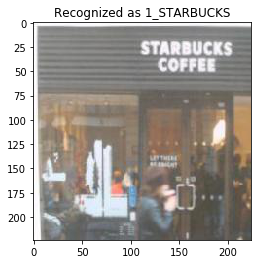

In [125]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 100

example_image = load_image(metadata2[test_idx][example_idx].image_path())
example_prediction = svc.predict([train_embeddings_otl[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

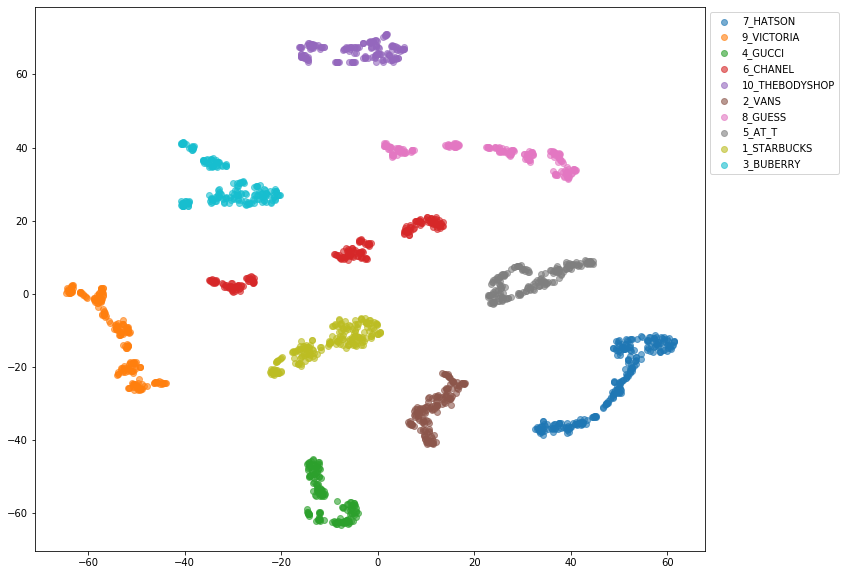

In [103]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(train_embeddings_otl)
plt.figure(figsize=(12,10))
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t, alpha=0.6)   

plt.legend(bbox_to_anchor=(1, 1));

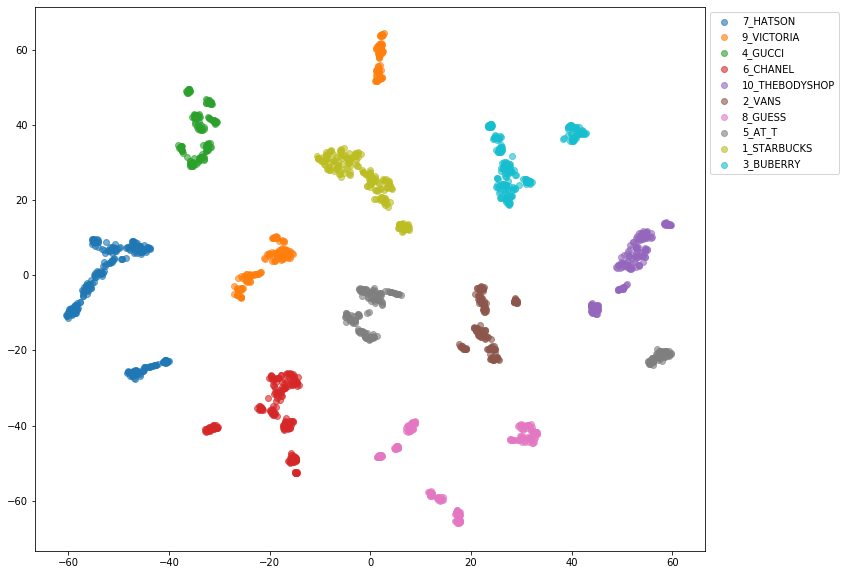

In [104]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(test_embeddings_otl)
plt.figure(figsize=(12,10))
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t, alpha=0.6)   

plt.legend(bbox_to_anchor=(1, 1));